# ID2222 Data Mining, Homework 3
# **Mining Data Streams**

Brando Chiminelli, Tommaso Praturlon

November 28th, 2022

## Goal
The goal of this notebook is to 

## How to run

In order to run this notebook you need to 

## Import libraries and read the dataset
In the following we import the few libraries needed for the project and we read the dataset.

We decided to read the first 2000 baskets from the dataset in order to reduce weight on memory. Our assumption is that items are uniformly distributed across the dataset, thus allowing us to have a good insight only from the given sample.

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
import statistics
import math

#PATH_TO_DATA = "../data/web-Stanford.txt"
PATH_TO_DATA = "../data/facebook_combined.txt"
df_graphs = pd.read_csv(PATH_TO_DATA, header=None)
print("Data read successfully!")

# Reduce dataset size for computation overload (temporary)
#df_graphs = df_graphs.iloc[0:50000]
print(df_graphs.head())
print("Number of rows: ", len(df_graphs))

Data read successfully!
     0
0  0 1
1  0 2
2  0 3
3  0 4
4  0 5
Number of rows:  88234


In [42]:
# DATA WRANGLING
# 1. remove text rows from dataset
# 2. create a dataset of integers
df_g = df_graphs
data = []
for i in range(len(df_g)):
    s = [int(x) for x in str(df_g.iloc[i][0]).split(' ')]
    #s = str(df_g.iloc[i][0]).split('\t')
    data.append(s)
#print(data)

In [13]:
'''
# DATA WRANGLING
# 1. remove text rows from dataset
# 2. create a dataset of integers
df_g = df_graphs.drop([0, 1, 2, 3, 4])
data = []
for i in range(len(df_g)):
    s = [int(x) for x in str(df_g.iloc[i][0]).split('\t')]
    #s = str(df_g.iloc[i][0]).split('\t')
    data.append(s)
#print(data)
'''

In [59]:
####################################
# TRIEST-BASE CLASS IMPLEMENTATION #
####################################
import random
import numpy as np
import matplotlib.pyplot as plt

class TriestBase:
    '''
    Implementation of the Trièst-base algorithm
    - function SampleEdge
    - function UpdateCounter
    - function FlipBiasedCoin
    '''
    
    def __init__(self,M):
        self._M = M
        self._tau = 0
        self._tau_loc = {}
        self._t = 0
        self._S = []
        self._tau_ls = []
    
    #M = 6
    
    def flipBiasedCoin(self, M, t):
        '''
        Flip a biased coin with probability M/t of falling head.
        '''
        # import numpy as np
        # 1: head, 0: tail
        result = np.random.choice([1, 0], p=[self._M/self._t, (1-self._M/self._t)])
        # print(f"Result: {result}, M/t: {self._M/self._t}")
        if result:
            return True
        else:
            return False
    
    def sampleEdge(self, edge, t):
        '''
        Receives the edge (u,v) as [u, v] and time t at which
        the stream element is received. t is a count integer.
        Returns a boolean
        '''
        #import random
        
        if (self._t <= self._M):
            #print(f"t: {self._t}, M: {self._M}")
            return True
        elif self.flipBiasedCoin(self._M, self._t):
            # select random edge from S
            random_edge = random.choice(self._S)
            # Delete random_edge from S
            self._S.remove(random_edge)
            # Update counters
            self.updateCounters('delete', random_edge)
            #print("Deleted.")
            return True
        else:
            return False
            
    def updateCounters(self, operation, edge):
        '''
        Receives the operation insertion or deletion
        and the edge.
        tau is the global counter
        e.g S = [[5,10], [10, 3], [12, 5], [12, 3]]
        edge = (5, 12)
        N_5 = (10, 12)
        N_12 = (5, 3)
        N_5_12 = (5, 12)
        '''
        # Define shared-neighborhood
        shared_neigh = set()
        neigh_u = set() # all neighbors of edge[0]
        neigh_v = set() # all nneighbors of edge[1]
        #print("S from updateCounters():\n", S)
        #print("_S:\n", self._S)
        u = edge[0]
        v = edge[1]
        for elem in self._S:
            # check that for the v in V_t (u,v) belongs to S
            # create neigh_u
            if u == elem[0]: # found u in position 0
                neigh_u.add(v) # add the other element
            if u == elem[1]: # found u in position 1
                neigh_u.add(u) # add the other element
            # create neigh_v
            if v == elem[0]: # found v in position 0
                neigh_v.add(v) 
            if v == elem[1]: # found v in position 1
                neigh_v.add(u)
        # shared neighbourhood is the intersection between the sets
        shared_neigh = set.intersection(neigh_u, neigh_v)
        self._tau_ls.append(self._tau)
        if operation == 'insert':
            # Insert
            for c in shared_neigh:
                self._tau += 1
                self._tau_loc[c] = self._tau_loc.get(c, 0) + 1
                self._tau_loc[u] = self._tau_loc.get(u, 0) + 1
                self._tau_loc[v] = self._tau_loc.get(v, 0) + 1
        else:
            # Delete
            for c in shared_neigh:
                self._tau -= 1
                self._tau_loc[c] = self._tau_loc.get(c, 0) - 1
                if self._tau_loc[c] <= 0:
                    del self._tau_loc[c]
                self._tau_loc[u] = self._tau_loc.get(u, 0) - 1
                if self._tau_loc[edge[0]] <= 0:
                    del self._tau_loc[u]
                self._tau_loc[v] = self._tau_loc.get(v, 0) - 1
                if self._tau_loc[v] <= 0:
                    del self._tau_loc[v]
                    
    def run_triest(self, data):
        print("Number of edges: ", len(data))
        for edge in data:
            self._t += 1
            if self.sampleEdge(edge, self._t):
                self._S.append(edge)
                #print("S before update counters: \n", S)
                self.updateCounters('insert', edge)
                #print("S after update counters: \n", S)
                #print("Tau: ", tau)
                
        # Return counters
        eps = max(1, (self._t * (self._t - 1) * (self._t - 2))/(self._M * (self._M - 1) * (self._M - 2)))
        print("tau: ", self._tau)
        print("eps: ", eps)
        est_tri = self._tau*eps
        print("Estimated triangles: ", est_tri)
        plt.plot(range(len(self._tau_ls)), self._tau_ls)
        plt.show()

In [44]:
# EXPLOITING THE CLASS TRIEST-BASE


Number of edges:  88234
tau:  144
eps:  10740.85743886422
Estimated triangles:  1546683.4711964475


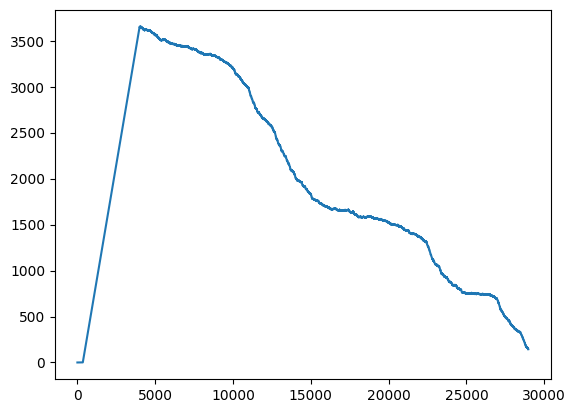

In [65]:
TriestBase(4000).run_triest(data)

In [7]:

'''
At time _t
Graph G_t = (set of verteces V_t, set of edges E_t) 
'''

S = []
M = 5
t = 0
tau = 0
tau_loc = {} # dictionary of local counts (u: counts) {5: 99, 12: 3, 2:1}

print("Number of edges: ", len(data))
# simulate the stream of data
for edge in data:
    t += 1
    #print(edge)
    if TriestBase().sampleEdge(edge, t, S, M, tau, tau_loc):
        S.append(edge)
        print("S before update counters: \n", S)
        S, tau, tau_loc = TriestBase().updateCounters('insert', edge, S, tau, tau_loc)
        print("S after update counters: \n", S)
        #print("Tau: ", tau)
        
# Epsilon
print(t)
eps = (t*(t-1)*(t-2))/(M*(M-1)*(M-2))
est_triangles = eps*tau
print("Eps: ", eps)
print("Tau: ", tau)
print("Estimated triangles: ", est_triangles)

# Graphs and statistics 
import matplotlib.pyplot as plt
from collections import Counter
'''
cnt = Counter(C_1.values())
plt.bar(cnt.keys(), cnt.values())

plt.xlabel('Frequency')
plt.ylabel('Number of documents with that frequency')
plt.show()
'''

"\ncnt = Counter(C_1.values())\nplt.bar(cnt.keys(), cnt.values())\n\nplt.xlabel('Frequency')\nplt.ylabel('Number of documents with that frequency')\nplt.show()\n"